# Exercise on synaptic connectivity

In this worksheet, we explore ways to query synaptic connectivity from the MICrONS dataset and combine it with cell type annotations and other parameters of cells.

This tutorial assumes you have followed the [tutorial for programmatic access](https://github.com/sdorkenw/MICrONS_workshop/blob/main/tutorials/ProgrammaticAccess.ipynb), at least for setting up your CAVE account. 

## Setup and imports

In [1]:
# !pip install caveclient

In [2]:
import caveclient

import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

In [3]:
datastack_name = "minnie65_public"
client = caveclient.CAVEclient(datastack_name)

# One can pass the token directly to the client:
# my_token = "your token goes here"
# client = caveclient.CAVEclient(datastack_name, auth_token=my_token)

## 1. Sorted wiring diagram

In the tutorial, we queried the neuronal connectivity but the resulting wiring diagram showed little structure. Here, we want to combine the synaptic connecitivty with cell type classifications (from the table `aibs_metamodel_celltypes_v661`) to sort the wiring diagram. A suggested order of operations is

1. Get the proofreading table (`proofreading_status_public_release`)
2. Get the cell type table (`aibs_metamodel_celltypes_v661`)
3. Join/merge the proofreading table and the cell type table using `pd.merge` on `pt_root_id`
4. Lookup the synapses of the entries in the resulting table and create synapse matrix
5. Sort the rows and columns of the synapse matrix using the cell type information (see `sort_matrix_by_label()` below)
6. Plot using `sns.heatmap`
7. Bonus: Plot using `sns.clustermap` without clustering (`row_cluster=False`, `col_cluster=False`) and passing colors to `row_colors` and `col_colors` to indicate the cell types)

Tip: The logic for all steps is contained in the tutorial.

In [4]:
def sort_matrix_by_types(mat: pd.DataFrame, 
                         labels: pd.DataFrame, 
                         label_type_col: str = "cell_type", 
                         label_id_col: str = "pt_root_id"):
    """Sorts (synapse) matrix by labels.

    This function assumes a square synapse matrix!

    Args:
        mat: synapse matrix as pandas DataFrame
        labels: DataFrame with labels, e.g. the output of client.materialize.query_table('aibs_metamodel_celltypes_v661')
        label_type_col: column name in labels for cell types
        label_id_col: column name in labels for root ids

    Returns:
        mat_sorted: sorted matrix
        mat_labels: sorted labels; has the same length as matrix
    """
    assert mat.shape[0] == mat.shape[1]
    
    mat_sorted = mat.copy()
    
    mat_labels = np.array(labels.set_index(label_id_col).loc[mat.index][label_type_col])
    sorting = np.argsort(mat_labels)
    
    mat_sorted = mat_sorted.iloc[sorting].T.iloc[sorting].T

    return mat_sorted, mat_labels[sorting]

1. Get the proofreading table (`proofreading_status_public_release`)

In [5]:
proof_df = client.materialize.query_table("proofreading_status_public_release", 
                                          filter_in_dict={"status_axon": ["clean", "extended"]})

2. Get the cell type table (`aibs_metamodel_celltypes_v661`)

In [6]:
ct_df = client.materialize.query_table("aibs_metamodel_celltypes_v661")
# remove segments with multiple cell bodies
ct_df = ct_df.drop_duplicates("pt_root_id", keep=False)

3. Join/merge the proofreading table and the cell type table using `pd.merge` on `pt_root_id`

In [7]:
proof_ct_df = pd.merge(proof_df, ct_df[["pt_root_id", "classification_system", "cell_type"]], on="pt_root_id", how="inner")

4. Lookup the synapses of the entries in the resulting table and create synapse matrix

In [8]:
synapse_table_name = client.info.get_datastack_info()["synapse_table"]
# Query
syn_df = client.materialize.query_table(synapse_table_name, 
                                        filter_in_dict={"pre_pt_root_id": proof_ct_df["pt_root_id"], 
                                                        "post_pt_root_id": proof_ct_df["pt_root_id"]})
# remove autapses
syn_df = syn_df[syn_df["pre_pt_root_id"] != syn_df["post_pt_root_id"]]

# Synapse matrix
syn_mat = syn_df.pivot_table(index="pre_pt_root_id", columns="post_pt_root_id", values="size", aggfunc="sum")

# Squaring the matrix
syn_mat = syn_mat.reindex(columns=syn_mat.index)

5. Sort the rows and columns of the synapse matrix using the cell type information (see `sort_matrix_by_label()` below)

In [9]:
syn_mat, syn_mat_cell_types = sort_matrix_by_types(syn_mat, proof_ct_df)

6. Plot using `sns.heatmap`


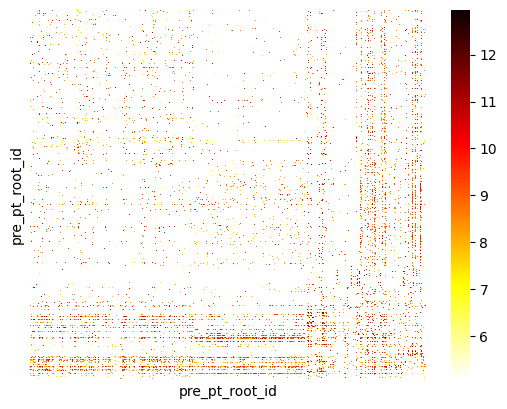

In [10]:
sns.heatmap(np.log(syn_mat), cmap="hot_r", xticklabels=[], yticklabels=[])
plt.show()

7. Bonus: Plot using `sns.clustermap` without clustering (`row_cluster=False`, `col_cluster=False`) and passing colors to `row_colors` and `col_colors` to indicate the cell types)

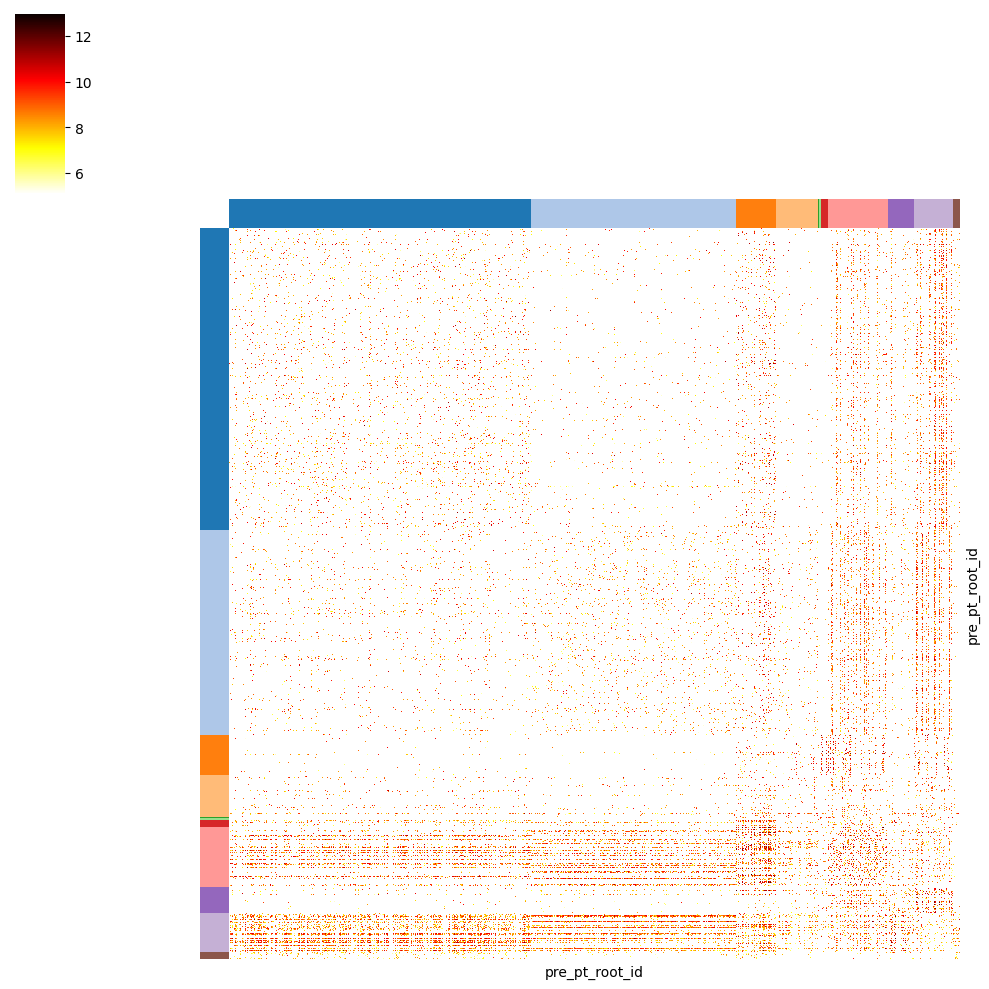

In [11]:
unique_cts, ct_idx = np.unique(syn_mat_cell_types, return_inverse=True)
ct_colors = plt.get_cmap("tab20")(ct_idx)

sns.clustermap(np.log(syn_mat), cmap="hot_r", xticklabels=[], yticklabels=[],
              row_cluster=False, col_cluster=False, row_colors=ct_colors, col_colors=ct_colors)
plt.show()

## 2. Distribution of synaptically targeted cell bodies

So far, we ignored that most neurons in the MICrONS dataset have well reconstructed dendrites (but not necessarily good axons). Here, we will use this feature of the dataset by looking at all the targets of a single neuron and find the soma locations of their postsynaptic targets.

First select a neuron to analyze - consider visualizing it in Neuroglancer and DashApss first. We suggest a neuron below but feel free to change that

In [12]:
root_id = 864691135155894884

The goal is to create a scatter plot that shows the cell body location of all the neurons targeted by our neuron of choice. We will use the synapse and the cell type tables to obtain the necessary information. Join them together to add the information about the postsynaptic cell body location to all synapses.

Bonus: Get creative with the annotations in the scatter plot. For instance, use cell types to color the postsynaptic target dots.

In [13]:
# Query synapses
synapse_table_name = client.info.get_datastack_info()["synapse_table"]
syn_df = client.materialize.query_table(synapse_table_name, 
                                        filter_in_dict={"pre_pt_root_id": [root_id]},
                                        split_positions=True,
                                        desired_resolution=[1000, 1000, 1000])

# remove autapses
syn_df = syn_df[syn_df["pre_pt_root_id"] != syn_df["post_pt_root_id"]]

In [14]:
# Query cell types
ct_df = client.materialize.query_table("aibs_metamodel_celltypes_v661", split_positions=True,
                                       desired_resolution=[1000, 1000, 1000], 
                                       filter_in_dict={"classification_system": ["inhibitory_neuron", "excitatory_neuron"]})

# remove segments with multiple cell bodies
ct_df = ct_df.drop_duplicates("pt_root_id", keep=False)

In [15]:
# Merge synapse and cell type information
syn_ct_df = pd.merge(syn_df, 
                     ct_df[["pt_root_id", "classification_system", "cell_type", "pt_position_x", "pt_position_y", "pt_position_z"]].rename(columns={"pt_root_id": "post_pt_root_id", "pt_position_x": "post_nuc_position_x", "pt_position_y": "post_nuc_position_y", "pt_position_z": "post_nuc_position_z"}), 
                     on="post_pt_root_id")

In [16]:
# Position of cell of interest
cell_nuc_position = ct_df[ct_df["pt_root_id"] == root_id][["pt_position_x", "pt_position_y", "pt_position_z"]]

Text(0, 0.5, 'Depth ($\\mu m$)')

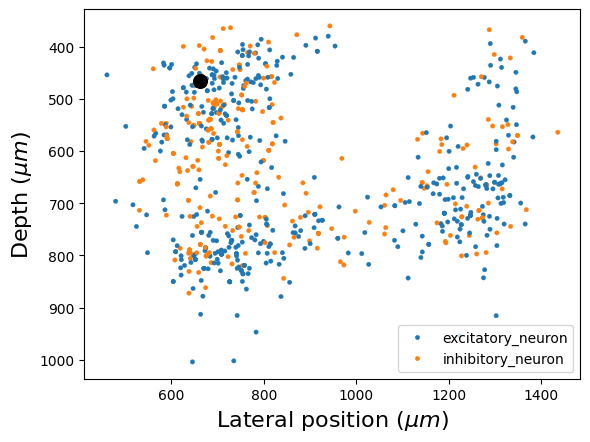

In [17]:
#Plot 

sns.scatterplot(data=syn_ct_df, x="post_nuc_position_x", y="post_nuc_position_y", edgecolor=None, s=10, hue="classification_system")
sns.scatterplot(data=cell_nuc_position, x="pt_position_x", y="pt_position_y", s=100, edgecolor=None, color="k")
plt.gca().invert_yaxis()
plt.xlabel("Lateral position ($\mu m$)", fontsize=16)
plt.ylabel("Depth ($\mu m$)", fontsize=16)

Text(0, 0.5, 'Depth ($\\mu m$)')

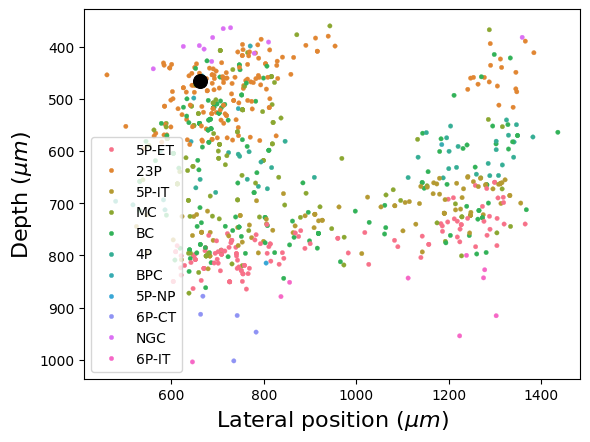

In [18]:
sns.scatterplot(data=syn_ct_df, x="post_nuc_position_x", y="post_nuc_position_y", edgecolor=None, s=10, hue="cell_type")
sns.scatterplot(data=cell_nuc_position, x="pt_position_x", y="pt_position_y", s=100, edgecolor=None, color="k")
plt.gca().invert_yaxis()
plt.xlabel("Lateral position ($\mu m$)", fontsize=16)
plt.ylabel("Depth ($\mu m$)", fontsize=16)

Text(0, 0.5, 'Depth ($\\mu m$)')

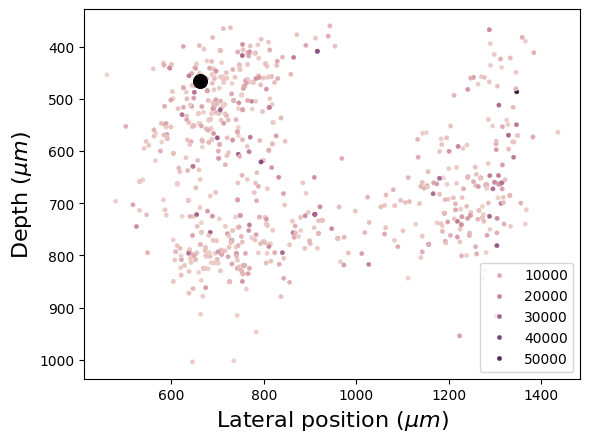

In [19]:
sns.scatterplot(data=syn_ct_df, x="post_nuc_position_x", y="post_nuc_position_y", edgecolor=None, s=10, hue="size")
sns.scatterplot(data=cell_nuc_position, x="pt_position_x", y="pt_position_y", s=100, edgecolor=None, color="k")
plt.gca().invert_yaxis()
plt.xlabel("Lateral position ($\mu m$)", fontsize=16)
plt.ylabel("Depth ($\mu m$)", fontsize=16)

### Bonus exercise: Synapse sorting

Synapse sorting describes the effect where different postsynaptic neurons are targeted more proximal or distal to the soma. For instance, multiple studies (e.g. [Schmid et al., 2017](https://www.nature.com/articles/nature24005) Fig. 2, [Dorkenwald, Li et al., 2023](https://www.nature.com/articles/s41592-023-02059-8) Fig. 6k-l) found that pyramidal cells target predominantly inhibitory neurons along their proximal axon and excitatory neurons along their distal axon. These studies used the path length along the soma, but some of the effect can be observed using eucliedian distance between the presynaptic soma and the synapse. 

Create a histogram of the distances of synapses onto inhibitory targets and one of the distances synapses onto excitatory targets and compare.

In [20]:
syn_ct_df["dist"] = np.linalg.norm(np.array(syn_ct_df[["pre_pt_position_x", "pre_pt_position_y", "pre_pt_position_z"]]) - np.array(cell_nuc_position), axis=1)

Text(0, 0.5, 'Normalized counts (A.U.)')

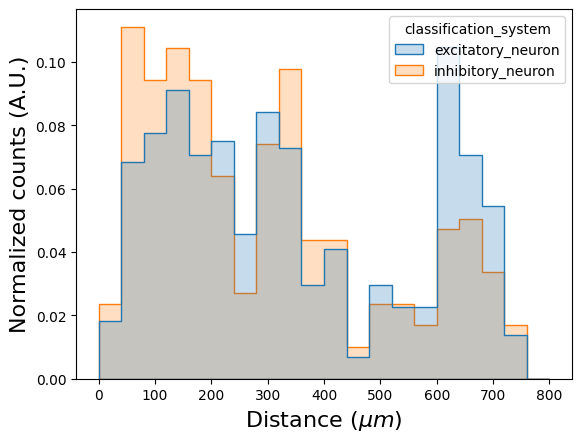

In [21]:
sns.histplot(data=syn_ct_df, x="dist", hue="classification_system", 
             bins=np.linspace(0, 800, 21), element="step", 
             stat="probability", common_norm=False)
plt.xlabel("Distance ($\mu m$)", fontsize=16)
plt.ylabel("Normalized counts (A.U.)", fontsize=16)

## 3. Functional connectomics

Lastly, we want to relate synaptic connectivity to structural measurements of the cells. This is an open area of analysis but the most common type of analysis is to quantify "like-to-like" connectivity. "Like-to-like" refers to an effect where neurons with similar properties tend to be more connected. For instance [Ko et al., 2011](https://www.nature.com/articles/nature09880) find that "We found that connection probability was related to the similarity of visually driven neuronal activity." 


Using difference in preferred direction as a measurement of functional similarity, evaluate whether neurons in the MICrONS dataset exhibit like-to-like connectivity. To make things simpler, consider a null model that uses a randomized version of the synapse table. The effect is likely dependent on cell types; consider only analyzing the connections between `23P` cells first.

In [22]:
def shortest_distance_on_circle_array(array1: np.ndarray, array2: np.ndarray):
    """Caluclates the elemntwise distance between two arrays in a radial system."""
    
    # Normalize the angles to be within the range [0, 2*pi)
    array1 = array1 % (2 * np.pi)
    array2 = array2 % (2 * np.pi)
    
    # Calculate the absolute differences
    delta = np.abs(array1 - array2)
    
    # Calculate the circular differences
    delta_prime = 2 * np.pi - delta
    
    # Return the minimum differences
    return np.minimum(delta, delta_prime)

In [23]:
# Query functional data

func_df = client.materialize.query_table("functional_properties_v3_bcm")
func_df = func_df.drop_duplicates("pt_root_id", keep="first")
func_df = func_df[func_df["gDSI"] > .05]

# Filter by cell type
ct_df = client.materialize.query_table("aibs_metamodel_celltypes_v661")
# remove segments with multiple cell bodies
ct_df = ct_df.drop_duplicates("pt_root_id", keep=False)

func_df = func_df[np.isin(func_df["pt_root_id"], ct_df[ct_df["cell_type"] == "4P"]["pt_root_id"])]
func_df

,id,created,valid,target_id,session,scan_idx,unit_id,pref_ori,pref_dir,gOSI,...,cc_abs,id_ref,created_ref,valid_ref,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position
18,8101,2024-01-22 08:09:51.497934+00:00,t,227790,9,3,2533,1.532929,4.674522,0.447399,...,0.723406,227790,2020-09-28 22:44:06.507628+00:00,t,217.187123,86004006220087587,864691135577813765,"[154320, 160640, 19029]","[nan, nan, nan]","[nan, nan, nan]"
22,5224,2024-01-22 08:09:51.497934+00:00,t,456149,5,7,4384,0.827002,0.827002,0.112717,...,0.252634,456149,2020-09-28 22:40:58.839136+00:00,t,289.305231,102045675449188892,864691135759371086,"[271184, 142656, 24723]","[nan, nan, nan]","[nan, nan, nan]"
24,7260,2024-01-22 08:09:51.497934+00:00,t,116028,9,3,5086,0.684959,3.826552,0.290684,...,0.335439,116028,2020-09-28 22:41:14.754883+00:00,t,241.045340,79882337525130587,864691136145003159,"[109664, 163600, 17036]","[nan, nan, nan]","[nan, nan, nan]"
26,2633,2024-01-22 08:09:51.497934+00:00,t,296761,5,6,5174,0.045936,0.045936,0.668752,...,0.487717,296761,2020-09-28 22:44:15.531111+00:00,t,234.560717,90436206713993499,864691136119541016,"[186720, 153056, 22293]","[nan, nan, nan]","[nan, nan, nan]"
42,9900,2024-01-22 08:09:51.497934+00:00,t,490669,9,3,5774,3.099089,6.240682,0.270342,...,0.373722,490669,2020-09-28 22:44:48.288091+00:00,t,285.574431,104791223965116502,864691135684176114,"[290960, 151696, 19193]","[nan, nan, nan]","[nan, nan, nan]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12068,5409,2024-01-22 08:09:51.497934+00:00,t,333163,7,5,7142,0.971039,4.112632,0.076602,...,0.805658,333163,2020-09-28 22:44:02.014723+00:00,t,205.628867,92619630648480940,864691135693568959,"[202480, 168016, 22413]","[nan, nan, nan]","[nan, nan, nan]"
12073,8697,2024-01-22 08:09:51.497934+00:00,t,260926,9,3,5214,3.064759,6.206352,0.140424,...,0.353939,260926,2020-09-28 22:44:19.059993+00:00,t,240.240558,89029313067794333,864691136389008656,"[176384, 156576, 23561]","[nan, nan, nan]","[nan, nan, nan]"
12080,4583,2024-01-22 08:09:51.497934+00:00,t,363746,9,3,5655,1.083119,4.224712,0.165413,...,0.346168,363746,2020-09-28 22:44:24.564020+00:00,t,248.633917,95010518816906778,864691136297102619,"[220000, 155616, 23118]","[nan, nan, nan]","[nan, nan, nan]"
12084,8540,2024-01-22 08:09:51.497934+00:00,t,226556,5,7,5084,1.625689,4.767282,0.559003,...,0.189372,226556,2020-09-28 22:44:04.584284+00:00,t,213.339668,86495488454979282,864691136266770932,"[158112, 152720, 23471]","[nan, nan, nan]","[nan, nan, nan]"


In [24]:
synapse_table_name = client.info.get_datastack_info()["synapse_table"]
# Query
syn_df = client.materialize.query_table(synapse_table_name, 
                                        filter_in_dict={"pre_pt_root_id": func_df["pt_root_id"], 
                                                        "post_pt_root_id": func_df["pt_root_id"]})
# remove autapses
syn_df = syn_df[syn_df["pre_pt_root_id"] != syn_df["post_pt_root_id"]]

In [25]:
# Claculate the geometric mean of multi-synaptic connections 
syn_gdf = syn_df.groupby(["pre_pt_root_id", "post_pt_root_id"])["size"].agg(lambda x: np.mean(np.log(x))).reset_index()

# Merge synapses with functional data
syn_gdf = pd.merge(syn_gdf, func_df[["pt_root_id", "pref_dir"]].rename(columns={"pt_root_id": "pre_pt_root_id", "pref_dir": "pre_pref_dir"}), on="pre_pt_root_id")
syn_gdf = pd.merge(syn_gdf, func_df[["pt_root_id", "pref_dir"]].rename(columns={"pt_root_id": "post_pt_root_id", "pref_dir": "post_pref_dir"}), on="post_pt_root_id")

# Compute difference in preferred direction
syn_gdf["pref_dir_d"] = shortest_distance_on_circle_array(np.array(syn_gdf["pre_pref_dir"]), np.array(syn_gdf["post_pref_dir"]))

In [26]:
# Random null hypothesis
rand_idx = np.arange(len(syn_gdf))
np.random.shuffle(rand_idx)

# Compute difference in preferred direction
rand_pref_ori_d = shortest_distance_on_circle_array(np.array(syn_gdf["pre_pref_dir"]), np.array(syn_gdf.iloc[rand_idx]["post_pref_dir"]))

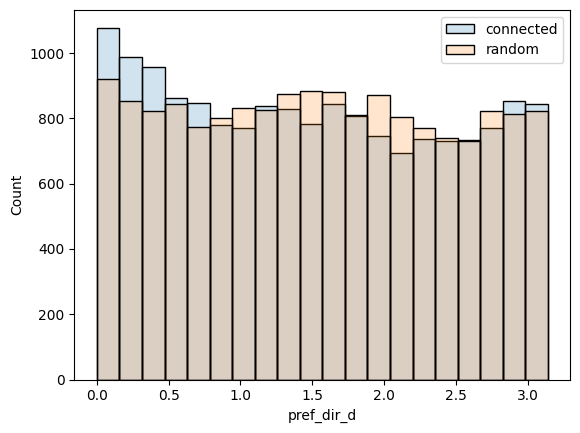

In [27]:
sns.histplot(data=syn_gdf, x="pref_dir_d", alpha=.2, bins=np.linspace(0, np.pi, 21), label="connected")
sns.histplot(rand_pref_ori_d, alpha=.2, bins=np.linspace(0, np.pi, 21), label="random")
plt.legend()